In [1]:
import pandas as pd
import numpy as np
from random import randint
from math import exp

In [2]:
df = pd.read_csv('spambase.data',delim_whitespace=False,header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


#### Switching non-spam labels from 0 to -1

In [3]:
for row in range(df.shape[0]):
    if df.at[row,57] == 0:
        df.at[row,57] = -1

#### Normalisation of data

In [4]:
all_data = df.as_matrix()
features = all_data[:,:-1]
labels = all_data[:,-1]
mu = np.mean(features,axis=0)
var = features.var(axis=0)
normalised = (features-mu)/np.sqrt(var)

In [5]:
# don't forget to add a column of ones!
constant_coefficient = np.ones((labels.shape[0],1))

In [6]:
data = np.concatenate((constant_coefficient,normalised,labels.reshape((labels.shape[0],1))),axis=-1)

#### Shuffle and split data

In [7]:
from sklearn.utils import shuffle
data = shuffle(data,random_state=1338)

N = data.shape[0]
split = 0.2
y_train = data[int(split*N):, -1]
X_train = data[int(split*N):, :-1]

y_test = data[:int(split*N), -1]
X_test = data[:int(split*N), :-1]

### The actual Logistic Regression classifier

In [8]:
class LogisticRegression:
    
    def calc_prob(self,y,Beta,x):
        return 1 / (1 + exp(-y * np.dot(Beta.T, x)))
    
    def train(self,X_train,y_train,iterations=5):
        self.X_train = X_train
        self.y_train = y_train
        self.Beta = np.mean(self.X_train,axis=0)
        delta = 0.01
        P = np.full(self.X_train.shape[0],0.5)
        for iteration in range(iterations):
            for row in range(self.X_train.shape[0]):
                P[row] = self.calc_prob(self.y_train[row],self.Beta,self.X_train[row,:])
            sum_corrections = np.sum((self.y_train.reshape((self.y_train.shape[0],1))*self.X_train*(1-P.reshape((P.shape[0],1)))),axis=0)
            self.Beta = self.Beta + (delta*sum_corrections)
            #delta = delta / 10
            
    def predict(self,X_test,y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.test_rows = y_test.shape[0]
        predictions = []
        for row in range(X_test.shape[0]):
            pos_prob = self.calc_prob(1,self.Beta,X_test[row,:])
            neg_prob = 1 - pos_prob
            if pos_prob >= neg_prob:
                predictions.append(1)
            else:
                predictions.append(-1)
        self.pred_array = np.array(predictions)
        
    def error_rate(self):
        bools = np.equal(self.pred_array,self.y_test.flatten())
        correct = np.sum(bools)
        return (self.test_rows-correct)/self.test_rows
        #return pred
        
    def changelabels(self,arrtochange):
        """in labels, changes all positive numbers to 0s and all negative numbers to 1s"""
        result = np.zeros((arrtochange.size))
        for i in range(arrtochange.size):
            if arrtochange[i] >= 0:
                result[i] = 0
            else:
                result[i] = 1
        return result
    
    def confusion_matrix(self):
        preds = self.changelabels(self.pred_array).flatten()
        testlabels = self.y_test
        changedtestlabels = self.changelabels(testlabels)
        mtrx = np.zeros((2,2))
        for i in range(self.test_rows):
            mtrx[int(changedtestlabels[i]),int(preds[i])] += 1
        return mtrx

### Spam classifier

#### Testing up to 20 iterations

In [9]:
iterations = list(range(1,21))
errors = []
for iteration in iterations:
    logreg = LogisticRegression()
    logreg.train(X_train,y_train,iterations=iteration)
    logreg.predict(X_test,y_test)
    errors.append(logreg.error_rate())
    print("Error rate for",iteration,"iterations =",logreg.error_rate())
    print("Success rate for",iteration,"iterations =",1-logreg.error_rate())
    print(logreg.confusion_matrix())
    
print("Lowest error rate at",iterations[np.argmin(np.array(errors))],"iterations with error rate of",errors[np.argmin(np.array(errors))])

Error rate for 1 iterations = 0.113043478261
Success rate for 1 iterations = 0.886956521739
[[ 314.   68.]
 [  36.  502.]]
Error rate for 2 iterations = 0.101086956522
Success rate for 2 iterations = 0.898913043478
[[ 321.   61.]
 [  32.  506.]]
Error rate for 3 iterations = 0.0989130434783
Success rate for 3 iterations = 0.901086956522
[[ 322.   60.]
 [  31.  507.]]
Error rate for 4 iterations = 0.095652173913
Success rate for 4 iterations = 0.904347826087
[[ 326.   56.]
 [  32.  506.]]
Error rate for 5 iterations = 0.0880434782609
Success rate for 5 iterations = 0.911956521739
[[ 333.   49.]
 [  32.  506.]]
Error rate for 6 iterations = 0.0923913043478
Success rate for 6 iterations = 0.907608695652
[[ 334.   48.]
 [  37.  501.]]
Error rate for 7 iterations = 0.0869565217391
Success rate for 7 iterations = 0.913043478261
[[ 340.   42.]
 [  38.  500.]]
Error rate for 8 iterations = 0.0902173913043
Success rate for 8 iterations = 0.909782608696
[[ 334.   48.]
 [  35.  503.]]
Error rate 

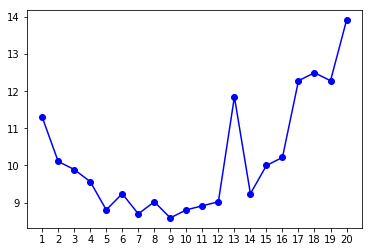

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.xticks(iterations)
plt.plot(iterations, [100*e for e in errors], 'bo-')

### Classification for and, or, xor

In [11]:
# again not forgetting to add the constant coefficient at the start
# here we replace 0 with -1 for the labels
and_ = np.array([[1,0,0,-1],[1,0,1,-1],[1,1,0,-1],[1,1,1,1]])
or_ = np.array([[1,0,0,-1],[1,0,1,1],[1,1,0,1],[1,1,1,1]])
xor_ = np.array([[1,0,0,-1],[1,0,1,1],[1,1,0,1],[1,1,1,-1]])

In [12]:
and_test = LogisticRegression()
and_test.train(and_[:,:-1],and_[:,-1],iterations=1)
and_test.predict(and_[:,:-1],and_[:,-1])
print("Error rate for and with 1 iteration =",and_test.error_rate())
print(and_test.confusion_matrix())

and_test = LogisticRegression()
and_test.train(and_[:,:-1],and_[:,-1],iterations=100)
and_test.predict(and_[:,:-1],and_[:,-1])
print("Error rate for and with 100 iterations =",and_test.error_rate())
print(and_test.confusion_matrix())

Error rate for and with 1 iteration = 0.75
[[ 1.  0.]
 [ 3.  0.]]
Error rate for and with 100 iterations = 0.0
[[ 1.  0.]
 [ 0.  3.]]


In [13]:
or_test = LogisticRegression()
or_test.train(or_[:,:-1],or_[:,-1],iterations=1)
or_test.predict(or_[:,:-1],or_[:,-1])
print("Error rate for or with 1 iteration =",or_test.error_rate())
print(or_test.confusion_matrix())

or_test = LogisticRegression()
or_test.train(or_[:,:-1],or_[:,-1],iterations=500)
or_test.predict(or_[:,:-1],or_[:,-1])
print("Error rate for or with 500 iterations =",or_test.error_rate())
print(or_test.confusion_matrix())

Error rate for or with 1 iteration = 0.25
[[ 3.  0.]
 [ 1.  0.]]
Error rate for or with 500 iterations = 0.0
[[ 3.  0.]
 [ 0.  1.]]


In [14]:
xor_test = LogisticRegression()
xor_test.train(xor_[:,:-1],xor_[:,-1],iterations=1)
xor_test.predict(xor_[:,:-1],xor_[:,-1])
print("Error rate for xor with 1 iteration =",xor_test.error_rate())
print(xor_test.confusion_matrix())

# tested up to more than 1000 iterations and we don't get a better result than a 25% error rate
xor_test = LogisticRegression()
xor_test.train(xor_[:,:-1],xor_[:,-1],iterations=300)
xor_test.predict(xor_[:,:-1],xor_[:,-1])
print("Error rate for xor with 300 iterations =",xor_test.error_rate())
print(xor_test.confusion_matrix())

Error rate for xor with 1 iteration = 0.5
[[ 2.  0.]
 [ 2.  0.]]
Error rate for xor with 300 iterations = 0.25
[[ 2.  0.]
 [ 1.  1.]]
